# **Assignment Roadmap**

This assignment asks you to build a complete Brain-Computer Interface (BCI) pipeline. Your goal is to take raw, noisy electrical brain signals and turn them into a clear Yes/No decision: Is this the character the user wants?

**Theres not much theory to learn other than implementation, you have to learn this by doing**

## AI Usage Policy for This Assignment

You're welcome to use AI for this assignment. Given the complexity of EEG signal processing and machine learning,
We don't expect you to know every implementation detail from scratch and neither does any recuiter or any professor.


Use AI to:

    Debug errors and troubleshoot issues

    Understand concepts and explore different approaches

What matters:

    You understand your code and can explain how it works

    You learn from the process, not just copy-paste

### **1: Cleaning the Signal (Preprocessing)**

The Goal: Raw EEG data is full of "garbage" frequencies like muscle movement and electrical hum. You need to filter the data to keep only the brain waves relevant to the P300 response (typically 0.1Hz – 20Hz).

You have already done this in the previous assignment but this one is a more standard procedure.

Common Pitfalls:

    Filter Lag: Standard filters can delay the signal, meaning the brain response looks like it happened later than it actually did. To prevent this, use zero-phase filtering (e.g., scipy.signal.filtfilt) instead of standard filtering (lfilter).

    Aliasing: You are asked to downsample the data from 240Hz to 60Hz to make it faster to process. Do not simply slice the array (e.g., data[::4]) without filtering first. If you do, high-frequency noise will "fold over" into your low frequencies and corrupt the data. Always filter before downsampling.

### **2: Epoch Extraction**

The Goal: You need to convert the continuous stream of data into specific "events" or "epochs."

The Concept: A P300 response happens roughly 300ms after a flash. Your code needs to identify every moment a flash occurs (stimulus_onset), look forward in time (e.g., 800ms), and "snip" that window of data out.

Visualizing the Data Structure:

    Input: A continuous 2D matrix (Total_Time_Points, 64_Channels)

    Output: A 3D block of events (Number_of_Flashes, Time_Points_Per_Window, 64_Channels)

Common Pitfall:

    Indexing Errors: This dataset may originate from MATLAB (which uses 1-based indexing), while Python uses 0-based indexing. If your index calculation is off by even one sample, your window will shift, and the machine learning model will be training on random noise rather than the brain response. Double-check your start and end indices.

### **3: Making Data "Model-Ready" (Feature Engineering)**

The Goal: Standard Machine Learning models (like SVM or LDA) cannot understand 3D arrays. They generally require a 2D matrix (like an Excel sheet). The Task:

    Time Domain: You will need to "flatten" the epochs. If an epoch is 60 time points × 64 channels, it becomes a single flat row of 3,840 numbers.

    PCA/CSP: These are compression techniques. The goal is to reduce those 3,840 numbers down to perhaps 20 numbers that capture the most important information.

Common Pitfall:

    Data Leakage: When using PCA or CSP, you must be careful not to "cheat." You should .fit() your reducer only on the training data, and then .transform() the test data. If you fit on the combined dataset, your model "sees" the test answers ahead of time, leading to artificially high scores that won't work in the real world.

### **4: Classification**

The Goal: Feed your features into the ML models (LDA, SVM, etc.) provided in the skeleton code to classify "Target" vs. "Non-Target" flashes.

Common Pitfall:

    Class Imbalance: In a P300 speller, the letter the user wants (Target) only flashes 1 out of 6 times. The other 5 flashes are Non-Targets.

        If your model decides to simply guess "Non-Target" every single time, it will still achieve ~83% accuracy. This is a useless model.

        Do not rely solely on Accuracy. Check the F1-Score or the Confusion Matrix. A good model must be able to correctly identify the rare Target events, not just the frequent Non-Targets.

In [ ]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong

import os
import numpy as np
from google.colab import drive
from scipy import signal
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, filtfilt, iirnotch
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
################################################################################
# SECTION 1: DATA LOADING AND BASIC SETUP
################################################################################

# Character matrix (6x6) for P300 speller
CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
    """
    Load P300 BCI Competition III data
    Returns dictionary with signal, flashing, stimulus_code, stimulus_type, target_char
    """
    data = sio.loadmat(file_path)
    signal = data.get('Signal')
    flashing = data.get('Flashing')
    stimulus_code = data.get('StimulusCode')
    stimulus_type = data.get('StimulusType')
    target_char = data.get('TargetChar')
    return{'signal': signal , 'flashing': flashing.flatten() , 'stimulus_code': stimulus_code.flatten() ,'stimulus_type': stimulus_type.flatten() ,'target_char': target_char}

    # Training data has labels, test data doesn't


def get_char_from_codes(row_code, col_code):
    """Convert row/column stimulus codes to character"""
    row_idx = int(row_code) - 7
    col_idx = int(col_code) - 1
    return CHAR_MATRIX[row_idx, col_idx]

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
data = load_data(file_path)
print(f"Signal Shape: {data['signal'].shape}")
print(f"Target String: {data['target_char']}")

Mounted at /content/drive
Signal Shape: (85, 7794, 64)
Target String: ['EAEVQTDOJG8RBRGONCEDHCTUIDBPUHMEM6OUXOCFOUKWA4VJEFRZROLHYNQDW_EKTLBWXEPOUIKZERYOOTHQI']


In [ ]:
print(data.keys())

dict_keys(['signal', 'flashing', 'stimulus_code', 'stimulus_type', 'target_char'])


--- P300 Analysis Results ---
Mean Amplitude in Target: 5.734797015096131
Mean Amplitude in Non-Target: -0.37933011610741363
Difference in Mean Amplitudes: 6.114127131203545


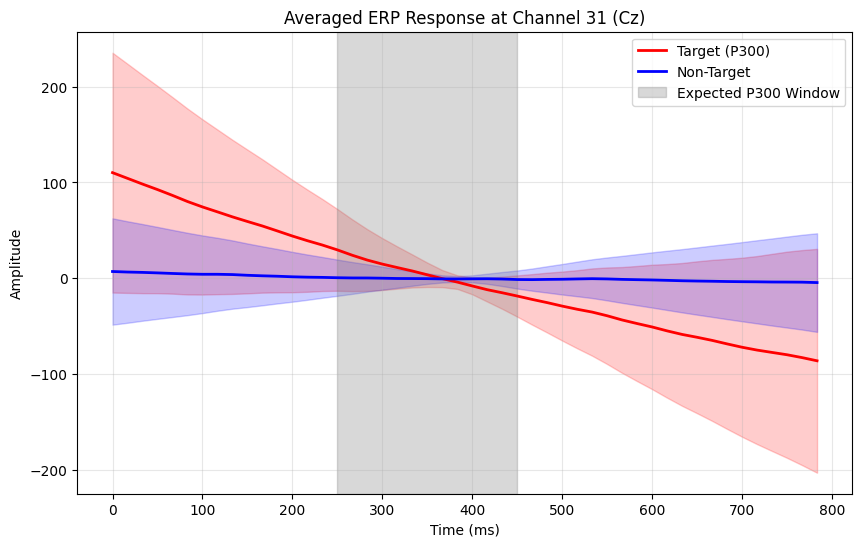

In [ ]:
################################################################################
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING
################################################################################

def bandpass_filter(signal_data, lowcut=0.1, highcut=20, fs=240, order=5):
    """
    Apply band-pass filter to remove low-frequency drift and high-frequency noise
    Typical P300 band: 0.1-20 Hz
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal_data, axis=1)

def notch_filter(signal_data, freq=50, fs=240, Q=30):
    """
    Remove powerline interference (50/60 Hz)
    """
    w0 = freq / (0.5 * fs)
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal_data, axis=1)

def baseline_correction(epoch, baseline_samples=50):
    """
    Apply baseline correction by subtracting pre-stimulus baseline
    """
    baseline = np.mean(epoch[:baseline_samples, :], axis=0)
    return epoch - baseline

def downsample_signal(signal_data, original_fs=240, target_fs=60):
    """
    Downsample signal to reduce computational load
    240 Hz -> 60 Hz reduces data by 4x
    """
    factor = int(original_fs / target_fs)
    return signal.decimate(signal_data, factor, axis=1)

def artifact_rejection(signal_data, threshold=100):
    """
    Simple artifact rejection based on amplitude threshold
    More advanced: use ICA or wavelet denoising
    """
    mask = np.any(np.abs(signal_data) > threshold, axis=(1, 2))
    return signal_data , mask

def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True,
                       apply_downsample=True, fs=240):
    """
    Complete preprocessing pipeline:
    1. Bandpass filtering (0.1-20 Hz)
    2. Notch filtering (50 Hz)
    3. Downsampling (240->60 Hz)
    """
    sig = data
    if apply_bandpass:
        sig = bandpass_filter(sig,fs=fs)
    if apply_notch:
        sig = notch_filter(sig,fs=fs)
    if apply_downsample:
        sig = downsample_signal(sig, original_fs=fs, target_fs=60)
    return sig

def extract_epochs(data,preprocessed_sig, epoch_length_ms=800, fs=60):
    """
    Extract epochs around stimulus onset
    - Event tagging: Use flashing signal to detect stimulus onset
    - Stimulus alignment: Extract fixed-length windows after each flash
    - Epoch extraction: Collect all stimulus-locked epochs
    Returns: Dictionary with epochs, labels, codes, character indices
    """
    samples_per_epoch = int((epoch_length_ms / 1000)*fs)
    if preprocessed_sig.ndim == 3:
      preprocessed_sig = preprocessed_sig.reshape(-1, preprocessed_sig.shape[-1])
    flashing = data['flashing'].flatten()
    stimulus_code = data['stimulus_code'].flatten()
    stimulus_type = data['stimulus_type'].flatten()
    all_targets = data['target_char']
    epochs, labels, codes_list = [], [], []
    onsets = np.where(np.diff(flashing, prepend=0) == 1)[0]
    for onset in  onsets:
      epoch = preprocessed_sig[onset : onset + samples_per_epoch, :]
      if epoch.shape[0] != samples_per_epoch:
        continue
      if np.max(np.abs(epoch)) > 20000:
        continue
      epoch = baseline_correction(epoch, baseline_samples=50)
      epochs.append(epoch)
      labels.append(stimulus_type[onset])
      codes_list.append(stimulus_code[onset])

    return {
        'epochs': epochs,
        'labels': labels,
        'codes': np.array(codes_list),
    }

def plot_erp_responses(epoch_data, channel_idx=31, fs=60):
    """
    Visualize ERP responses and confirm P300 peaks around 300ms
    Channel 31 = Cz (central midline electrode, best for P300)
    """
    epochs = np.array(epoch_data['epochs'])
    labels = np.array(epoch_data['labels'])
    channel_data = epochs[:, :, channel_idx]

    target_trials = channel_data[labels == 1]
    non_target_trials = channel_data[labels == 0]

    # Plot averages with standard error
    target_mean = np.mean(target_trials, axis=0)
    non_target_mean = np.mean(non_target_trials, axis=0)

    target_sem = np.std(target_trials, axis=0) / np.sqrt(len(target_trials))
    non_target_sem = np.std(non_target_trials, axis=0) / np.sqrt(len(non_target_trials))

    num_samples = target_mean.shape[0]
    time_points = np.arange(num_samples)*(1000/fs)
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, target_mean, color='red', label='Target (P300)', linewidth=2)
    plt.fill_between(time_points, target_mean - target_sem, target_mean + target_sem, color='red', alpha=0.2)
    plt.plot(time_points, non_target_mean, color='blue', label='Non-Target', linewidth=2)
    plt.fill_between(time_points, non_target_mean - non_target_sem, non_target_mean + non_target_sem, color='blue', alpha=0.2)

    # Mark P300 peak region
    p300_start_ms, p300_end_ms = 250, 450
    plt.axvspan(p300_start_ms, p300_end_ms, color='gray', alpha=0.3, label='Expected P300 Window')
    plt.title(f"Averaged ERP Response at Channel {channel_idx} (Cz)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Calculate P300 amplitude difference
    idx_start = int(p300_start_ms / 1000 * fs)
    idx_end = int(p300_end_ms / 1000 * fs)
    mean_amp_target = np.mean(target_mean[idx_start:idx_end])
    mean_amp_nontarget = np.mean(non_target_mean[idx_start:idx_end])
    diff = mean_amp_target - mean_amp_nontarget
    print(f"P300 Analysis Results")
    print(f"Mean Amplitude in Target: {mean_amp_target}")
    print(f"Mean Amplitude in Non-Target: {mean_amp_nontarget}")
    print(f"Difference in Mean Amplitudes: {diff}")

    plt.show()
raw_signals = data['signal']
preprocessed_sig = preprocess_pipeline(raw_signals, fs=240)
epoch_data = extract_epochs(data, preprocessed_sig, epoch_length_ms=800, fs=60)
plot_erp_responses(epoch_data=epoch_data, channel_idx=31, fs=60)


In [ ]:
################################################################################
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS
################################################################################

def extract_time_domain_features(epochs):
    """
    Extract time-domain features: simply flatten the epochs
    Shape: (n_epochs, n_samples * n_channels)
    """
    n_epochs = epochs.shape[0]
    n_samples = epochs.shape[1]
    n_channels = epochs.shape[2]
    epochs.reshape(n_epochs, n_samples * n_channels)
    return epochs.reshape(n_epochs, n_samples * n_channels)

def extract_pca_features(epochs, n_components=20):
    """
    Extract PCA features for dimensionality reduction
    Reduces (n_samples * n_channels) to n_components
    https://www.geeksforgeeks.org/machine-learning/implementing-pca-in-python-with-scikit-learn/
    """
    pca = PCA(n_components=n_components)
    features = pca.fit_transform(epochs.reshape(epochs.shape[0], -1))
    return features

def extract_csp_features(epochs, labels, n_components=6):
    """
    Common Spatial Patterns (CSP) for discriminative spatial filters
    Finds spatial filters that maximize variance ratio between classes
    """
    target_epochs = epochs[labels == 1]
    non_target_epochs = epochs[labels == 0]
    print(f"Target epochs for CSP: {len(target_epochs)}")
    print(f"Non-target epochs for CSP: {len(non_target_epochs)}")

    # Compute covariance matrices
    def compute_cov(data):
      data = np.transpose(data, (0, 2, 1))
      covs = []
      for i in data:
        cov = np.dot(i, i.T)
        cov = cov/np.trace(cov)
        covs.append(cov)
      return np.mean(covs, axis = 0)

    # Solve generalized eigenvalue problem


    # Sort by eigenvalues


    # Select most discriminative components (extreme eigenvalues)


    # Extract CSP features (log variance)




def extract_features(epoch_data, method='pca', n_components=20):
    """
    Feature extraction wrapper supporting multiple methods:
    - time_domain: Raw time-domain samples (flattened)
    - pca: Principal Component Analysis
    - csp: Common Spatial Patterns
    """


def train_lda_classifier(X_train, y_train):
    """
    Linear Discriminant Analysis with balanced priors
    https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
    """


def train_logistic_regression(X_train, y_train):
    """
    Logistic Regression - baseline classifier
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    """


def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive classifier evaluation
    """


class CSPTransformer:
    """
    Wrapper for CSP filters to enable transform() method
    """


In [ ]:
################################################################################
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS
################################################################################

def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    """
    Support Vector Machine with RBF kernel
    Good for non-linear decision boundaries
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)



def train_random_forest(X_train, y_train, n_estimators=100):
    """
    Random Forest Classifier
    Ensemble method, robust to overfitting
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    """


def train_gradient_boosting(X_train, y_train, n_estimators=100):
    """
    Gradient Boosting Classifier with manual sample weighting
    (GradientBoosting doesn't support class_weight parameter)
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    """
    print(f"\n  Training Gradient Boosting (n_estimators={n_estimators})...")

    # Calculate sample weights manually



def compare_all_classical_models(X_train, y_train, X_test, y_test):
    """
    Train and compare all classical ML models
    Returns performance comparison
    """


    # Calculate sample weights once for methods that need it


    # Define models to train


        # Training


        # Inference


        # Metrics


    # Summary table



def save_model(model, filepath):
    """Save model to pickle file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")

def load_model(filepath):
    """Load model from pickle file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model

In [ ]:
    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: LOADING DATA")
    print("="*70)

    from google.colab import drive

    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/eea/Dataset/'

    train_data_A = load_data(DATA_PATH + 'Subject_A_Train.mat')
    test_data_A = load_data(DATA_PATH + 'Subject_A_Test.mat')
    train_data_B = load_data(DATA_PATH + 'Subject_B_Train.mat')
    test_data_B = load_data(DATA_PATH + 'Subject_B_Test.mat')


In [ ]:
    # ========================================================================
    # STEP 2: PREPROCESSING
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: PREPROCESSING")
    print("="*70)

    print("\n--- Subject A ---")
    train_proc_A = preprocess_pipeline(train_data_A)
    test_proc_A = preprocess_pipeline(test_data_A)

    print("\n--- Subject B ---")
    train_proc_B = preprocess_pipeline(train_data_B)
    test_proc_B = preprocess_pipeline(test_data_B)


In [ ]:
    # ========================================================================
    # STEP 3: EPOCH EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: EPOCH EXTRACTION")
    print("="*70)

    print("\n--- Subject A ---")
    train_epochs_A = extract_epochs(train_proc_A)
    test_epochs_A = extract_epochs(test_proc_A)

    print("\n--- Subject B ---")
    train_epochs_B = extract_epochs(train_proc_B)
    test_epochs_B = extract_epochs(test_proc_B)

In [ ]:
    # ========================================================================
    # STEP 4: VISUALIZE ERP
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: VISUALIZING ERP RESPONSES")
    print("="*70)

    print("\n--- Subject A ---")
    plot_erp_responses(train_epochs_A, channel_idx=31)

In [ ]:
    # ========================================================================
    # STEP 5: FEATURE EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 5: FEATURE EXTRACTION")
    print("="*70)

    # ========================================================================
    # Subject A: Compare PCA vs CSP vs Time-Domain
    # ========================================================================
    print("\n--- Subject A: Feature Comparison ---")

    # Try PCA (20 components)


    # Try PCA (50 components)


    # Try CSP


    # Try Raw Time-Domain Features

    # Flatten epochs: (n_epochs, n_samples, n_channels) -> (n_epochs, n_samples * n_channels)


    # Quick comparison with BALANCED LDA


    # PCA-20 test

    # PCA-50 test


    # CSP test


    # Time-Domain test


    # Use LinearSVC (faster than SVM for high-dimensional data)

    # ========================================================================

    print("\n" + "="*70)
    print("FEATURE COMPARISON (Balanced Classifiers)")
    print("="*70)
    print(f"PCA (20 comp):      Accuracy={acc_pca20:.4f}, F1={f1_pca20:.4f}")
    print(f"PCA (50 comp):      Accuracy={acc_pca50:.4f}, F1={f1_pca50:.4f}")
    print(f"CSP (6 comp):       Accuracy={acc_csp:.4f}, F1={f1_csp:.4f}")
    print(f"Time-Domain (3072): Accuracy={acc_time:.4f}, F1={f1_time:.4f}")

    # Select best method based on F1-score


  # ========================================================================
# Subject A: Create final train/val split for later steps
# ========================================================================
X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
    X_train_full_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
)
print(f"\nSubject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")

# Transform test data
if feature_method_A == 'time':
    X_test_A = test_epochs_A['epochs'].reshape(len(test_epochs_A['epochs']), -1)
elif feature_method_A == 'pca':
    X_test_A = feature_obj_A.transform(test_epochs_A['epochs'].reshape(test_epochs_A['epochs'].shape[0], -1))
else:  # CSP
    X_test_A = feature_obj_A.transform(test_epochs_A['epochs'])

print(f"Test features: {X_test_A.shape}")

# ========================================================================
# Subject B: Use same method as Subject A
# ========================================================================
print("\n--- Subject B: Feature Extraction ---")
print(f"\nUsing {feature_method_A.upper()} (same as Subject A)...")

if feature_method_A == 'time':
    X_train_full_B = train_epochs_B['epochs'].reshape(len(train_epochs_B['epochs']), -1)
    X_test_B = test_epochs_B['epochs'].reshape(len(test_epochs_B['epochs']), -1)
elif feature_method_A == 'pca':
    X_train_full_B, pca_B = extract_features(train_epochs_B, method='pca', n_components=n_components_A)
    X_test_B = pca_B.transform(test_epochs_B['epochs'].reshape(test_epochs_B['epochs'].shape[0], -1))
else:  # CSP
    X_train_full_B, csp_B = extract_features(train_epochs_B, method='csp', n_components=6)
    X_test_B = CSPTransformer(csp_B).transform(test_epochs_B['epochs'])

X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(
    X_train_full_B, train_epochs_B['labels'], test_size=0.2, random_state=42, stratify=train_epochs_B['labels']
)
print(f"Subject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}, Test features: {X_test_B.shape}")


    print(f"\nSubject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}")
    print(f"Test features: {X_test_B.shape}")

    # Store feature objects for later use





In [ ]:
    # ========================================================================
    # STEP 6: BASELINE CLASSIFIERS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
    print("="*70)

    lda_A = train_lda_classifier(X_train_A, y_train_A)
    acc_lda = evaluate_classifier(lda_A, X_val_A, y_val_A, "LDA")

    lr_A = train_logistic_regression(X_train_A, y_train_A)
    acc_lr = evaluate_classifier(lr_A, X_val_A, y_val_A, "Logistic Regression")


In [ ]:
    # ========================================================================
    # STEP 7: CLASSICAL ML MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
    print("="*70)

    results_classical_A, models_A = compare_all_classical_models(
        X_train_A, y_train_A, X_val_A, y_val_A
    )

    # Train SVM for both subjects (best model)
    svm_A, scaler_A = train_svm_classifier(X_train_A, y_train_A)
    svm_B, scaler_B = train_svm_classifier(X_train_B, y_train_B)

In [ ]:
    # ========================================================================
    # STEP 8: EXPORT MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8: EXPORTING MODELS")
    print("="*70)

    import os
    os.makedirs('models', exist_ok=True)

    # Save pickle
    save_model({
        'model': svm_A,
        'scaler': scaler_A,
        'pca': pca_A
    }, 'models/subject_A_svm.pkl')

    save_model({
        'model': svm_B,
        'scaler': scaler_B,
        'pca': pca_B
    }, 'models/subject_B_svm.pkl')

